In [24]:
## Table & Visualization Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import pickle
import json

## Prediction Libraries
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, plot_confusion_matrix, auc, roc_curve

## Cross-Validation Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

## Model Libraries
from sklearn.tree import DecisionTreeClassifier

In [25]:
## Change this to your new training data
df = pd.read_csv("df_cleaned.csv")
df = df.drop_duplicates(subset='website')

In [26]:
df.head()

,Unnamed: 0,merchant_name,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist,contact_us_score,tnc_score,links_response,website,fraud_score,label
0,0,CV.ASIATRIPINDONESIA,0.000000,1.0,1.0,1.0,0.0,1.0,1.0,100.0,100.0,{'https://asiatrip.id/reseller/': '<Response [...,http://asiatrip.id/,0.000000,APPROVED
1,1,Pt.BloomingLotusYoga,70.000000,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,{'http://www.blooming-lotus-yoga.com/bliss-mag...,https://www.blooming-lotus-yoga.com,0.000000,APPROVED
2,2,YayasanGreenSejahtera,11.111111,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,"{'': 'No Response/Timeout', 'https://greenseja...",https://greensejahterafoundation.com/,0.000000,APPROVED
3,3,PTMatairTerraSolusi,12.500000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"{'': 'No Response/Timeout', 'https://www.matai...",http://www.matair.co.id,0.666667,APPROVED
4,4,SimplyMii,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,100.0,0.0,{'https://www.simplymii.com/products/category/...,https://www.simplymii.com/,0.000000,APPROVED


In [27]:
df.groupby("label").size()

label
APPROVED    215
REJECTED     77
dtype: int64

In [28]:
df.shape

(292, 15)

In [29]:
# trained_tf_idf_df = df[(df.label == 'APPROVED') & (df.tnc_refund_policy_exist == 1)]\
# .sample(n=50, replace=False, random_state=50)
# trained_tf_idf_df.to_csv("train_tf_idf.csv", index=False)
# df = df[~df.website.isin(trained_tf_idf_df.website)]

In [30]:
# df.groupby("label").size()

In [31]:
y = df['label'].apply(lambda x: 1 if x == 'REJECTED' else 0)

In [32]:
X = df.iloc[:, 2:9]

## Train/Test Split

In [33]:
X.head(1)

,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist
0,0.0,1.0,1.0,1.0,0.0,1.0,1.0


In [34]:
X.columns

Index(['broken_link_score', 'link_contact_us_exist', 'cu_email_exist',
       'cu_phone_number_exist', 'link_about_us_exist', 'link_tnc_exist',
       'tnc_refund_policy_exist'],
      dtype='object')

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [36]:
## Gaussian Naive Bayes has a good ability to predict REJECTED websites, but it is hard to got a low FP Rate with this model.
## While XGBoost provides more reliable model with low FP rate and enough TP rate
## Though, it goes back to the business decision which rate is more important

# model_choice = GaussianNB()
# model_choice = BernoulliNB()
# model_choice = MultinomialNB()
# model_choice = XGBClassifier(**params)
model_choice = DecisionTreeClassifier()

In [37]:
clf = model_choice
clf = clf.fit(X_train, y_train)

In [38]:
## Using the best TPR threshold
# y_pred = (clf.predict_proba(X_test)[:,1] >= 0.7367280663362746).astype(bool)

In [39]:
## Using the default threshold == 0.5
y_pred = clf.predict(X_test)

In [40]:
y_pred_proba = clf.predict_proba(X_test)

In [41]:
np.round(accuracy_score(y_test, y_pred), 2)

0.87

In [42]:
y_train.value_counts(), y_test.value_counts()

(0    141
 1     54
 Name: label, dtype: int64,
 0    74
 1    23
 Name: label, dtype: int64)

In [43]:
## Confusion matrix with best TPR threshold
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [44]:
tpr, fpr = np.round((tp/(tp+fn), fp/(fp+tn)), 3)
## TPR = Dari semua REJECTED merchant berapa % yang berhasil kereject, 
## FPR = Dari semua APPROVED berapa % yang kita salah tebak sebagai REJECTED
## This rate applies to a default threshold of 0.5
tpr, fpr

(0.783, 0.108)

In [45]:
tn, fp, fn, tp

(66, 8, 5, 18)

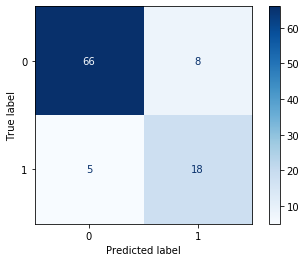

In [46]:
## This matrix visualization is based on 0.5 threshold
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [47]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

In [48]:
auc_score = auc(fpr, tpr)

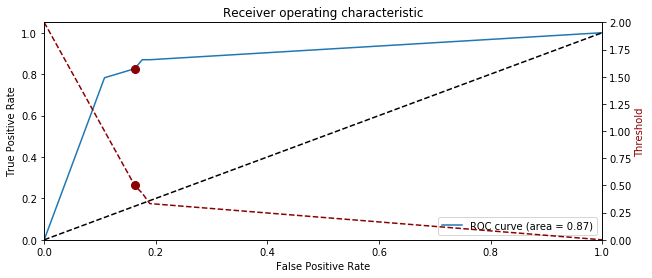

 -- Optimum Threshold -- 
        fpr       tpr     1-fpr        tf  thresholds
2  0.162162  0.826087  0.837838 -0.011751         0.5


In [49]:
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# find optimum thresholds
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i).apply(lambda x: x), 'thresholds' : pd.Series(thresholds, index = i)})
df_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

plt.plot(df_thresh['fpr'], df_thresh['tpr'], marker='o', markersize=8, color='darkred')

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='darkred')
ax2.set_ylabel('Threshold',color='darkred')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])
ax2.plot(df_thresh['fpr'], df_thresh['thresholds'], marker='o', markersize=8, color='darkred')


plt.show()
print(" -- Optimum Threshold -- ")
print(df_thresh)

In [50]:
print("-- Best TPR Threshold -- ")
## Finding threshold where TPR > Optimum TPR but FPR stays below 15%
for i in range(len(fpr)):
#     if tpr[i] > 0.85 and fpr[i] < 0.20:
        print("TPR %s, FPR %s, Threshold %s" % (tpr[i], fpr[i], thresholds[i]))

-- Best TPR Threshold -- 
TPR 0.0, FPR 0.0, Threshold 2.0
TPR 0.782608695652174, FPR 0.10810810810810811, Threshold 1.0
TPR 0.8260869565217391, FPR 0.16216216216216217, Threshold 0.5
TPR 0.8695652173913043, FPR 0.17567567567567569, Threshold 0.42857142857142855
TPR 0.8695652173913043, FPR 0.1891891891891892, Threshold 0.3333333333333333
TPR 1.0, FPR 1.0, Threshold 0.0


## Bootstrapped

In [51]:
accuracy_list = []
auc_list = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    clf = model_choice
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
    auc_score = auc(fpr, tpr)
    
    accuracy_list.append(accuracy)
    auc_list.append(auc_score)
    print("Iteration %s: AUC:%s, Accuracy:%s" % (i, auc_score, accuracy))

Iteration 0: AUC:0.8947222222222222, Accuracy:0.8865979381443299
Iteration 1: AUC:0.8009634888438134, Accuracy:0.7835051546391752
Iteration 2: AUC:0.8243243243243243, Accuracy:0.8350515463917526
Iteration 3: AUC:0.8741438356164384, Accuracy:0.8762886597938144
Iteration 4: AUC:0.7692307692307692, Accuracy:0.8144329896907216
Iteration 5: AUC:0.846031746031746, Accuracy:0.8144329896907216
Iteration 6: AUC:0.8805288461538461, Accuracy:0.845360824742268
Iteration 7: AUC:0.8455555555555555, Accuracy:0.8247422680412371
Iteration 8: AUC:0.7542808219178082, Accuracy:0.7835051546391752
Iteration 9: AUC:0.8683901292596945, Accuracy:0.8762886597938144
Iteration 10: AUC:0.8967391304347827, Accuracy:0.8556701030927835
Iteration 11: AUC:0.7923427991886409, Accuracy:0.7938144329896907
Iteration 12: AUC:0.8608465608465609, Accuracy:0.8865979381443299
Iteration 13: AUC:0.825132275132275, Accuracy:0.8144329896907216
Iteration 14: AUC:0.8230593607305936, Accuracy:0.7938144329896907
Iteration 15: AUC:0.761

Iteration 128: AUC:0.8040540540540541, Accuracy:0.8247422680412371
Iteration 129: AUC:0.8569330199764983, Accuracy:0.8556701030927835
Iteration 130: AUC:0.8081668625146887, Accuracy:0.7938144329896907
Iteration 131: AUC:0.810391363022942, Accuracy:0.8041237113402062
Iteration 132: AUC:0.8681818181818182, Accuracy:0.8556701030927835
Iteration 133: AUC:0.8025362318840581, Accuracy:0.845360824742268
Iteration 134: AUC:0.8554766734279919, Accuracy:0.8865979381443299
Iteration 135: AUC:0.782010582010582, Accuracy:0.7628865979381443
Iteration 136: AUC:0.7514269406392693, Accuracy:0.7731958762886598
Iteration 137: AUC:0.8528202115158636, Accuracy:0.8350515463917526
Iteration 138: AUC:0.776388888888889, Accuracy:0.8144329896907216
Iteration 139: AUC:0.8428571428571429, Accuracy:0.7835051546391752
Iteration 140: AUC:0.8290909090909091, Accuracy:0.865979381443299
Iteration 141: AUC:0.8132275132275133, Accuracy:0.8144329896907216
Iteration 142: AUC:0.9029411764705882, Accuracy:0.8762886597938144


Iteration 252: AUC:0.8139303482587065, Accuracy:0.8144329896907216
Iteration 253: AUC:0.8378306878306878, Accuracy:0.845360824742268
Iteration 254: AUC:0.831592039800995, Accuracy:0.8041237113402062
Iteration 255: AUC:0.7499999999999999, Accuracy:0.7731958762886598
Iteration 256: AUC:0.8566392479435958, Accuracy:0.8762886597938144
Iteration 257: AUC:0.7915821501014199, Accuracy:0.8247422680412371
Iteration 258: AUC:0.8375771604938271, Accuracy:0.845360824742268
Iteration 259: AUC:0.8416095890410957, Accuracy:0.8762886597938144
Iteration 260: AUC:0.8620129870129869, Accuracy:0.8350515463917526
Iteration 261: AUC:0.8272486772486772, Accuracy:0.8762886597938144
Iteration 262: AUC:0.7506747638326585, Accuracy:0.8144329896907216
Iteration 263: AUC:0.8483772819472617, Accuracy:0.8762886597938144
Iteration 264: AUC:0.7854497354497354, Accuracy:0.7731958762886598
Iteration 265: AUC:0.8584018801410106, Accuracy:0.8144329896907216
Iteration 266: AUC:0.7958839406207828, Accuracy:0.824742268041237

Iteration 377: AUC:0.8031746031746032, Accuracy:0.8041237113402062
Iteration 378: AUC:0.7803030303030303, Accuracy:0.7938144329896907
Iteration 379: AUC:0.8460606060606061, Accuracy:0.8556701030927835
Iteration 380: AUC:0.7997159090909092, Accuracy:0.7835051546391752
Iteration 381: AUC:0.8503246753246754, Accuracy:0.8350515463917526
Iteration 382: AUC:0.7920094007050529, Accuracy:0.7835051546391752
Iteration 383: AUC:0.8100529100529101, Accuracy:0.7938144329896907
Iteration 384: AUC:0.8700828157349896, Accuracy:0.8350515463917526
Iteration 385: AUC:0.7425925925925925, Accuracy:0.7628865979381443
Iteration 386: AUC:0.8288359788359789, Accuracy:0.8144329896907216
Iteration 387: AUC:0.858162100456621, Accuracy:0.845360824742268
Iteration 388: AUC:0.8225, Accuracy:0.8041237113402062
Iteration 389: AUC:0.8680931744312026, Accuracy:0.865979381443299
Iteration 390: AUC:0.8783856988082339, Accuracy:0.8762886597938144
Iteration 391: AUC:0.8912671232876713, Accuracy:0.8350515463917526
Iteration 

Iteration 508: AUC:0.8798472385428907, Accuracy:0.8969072164948454
Iteration 509: AUC:0.8247800586510264, Accuracy:0.8247422680412371
Iteration 510: AUC:0.8844444444444444, Accuracy:0.8762886597938144
Iteration 511: AUC:0.8523835319609967, Accuracy:0.8762886597938144
Iteration 512: AUC:0.8621212121212122, Accuracy:0.8762886597938144
Iteration 513: AUC:0.7297160243407709, Accuracy:0.7216494845360825
Iteration 514: AUC:0.835820895522388, Accuracy:0.8247422680412371
Iteration 515: AUC:0.860248447204969, Accuracy:0.8556701030927835
Iteration 516: AUC:0.888157894736842, Accuracy:0.845360824742268
Iteration 517: AUC:0.7683284457478005, Accuracy:0.7835051546391752
Iteration 518: AUC:0.8273401826484019, Accuracy:0.8041237113402062
Iteration 519: AUC:0.8030555555555555, Accuracy:0.8350515463917526
Iteration 520: AUC:0.8155555555555556, Accuracy:0.8247422680412371
Iteration 521: AUC:0.7952329360780065, Accuracy:0.8144329896907216
Iteration 522: AUC:0.8121212121212121, Accuracy:0.845360824742268


Iteration 639: AUC:0.8678223185265439, Accuracy:0.8762886597938144
Iteration 640: AUC:0.8272486772486773, Accuracy:0.8041237113402062
Iteration 641: AUC:0.8331643002028397, Accuracy:0.845360824742268
Iteration 642: AUC:0.908390410958904, Accuracy:0.865979381443299
Iteration 643: AUC:0.7629259694477085, Accuracy:0.8247422680412371
Iteration 644: AUC:0.8335921325051759, Accuracy:0.8144329896907216
Iteration 645: AUC:0.8906469760900141, Accuracy:0.8762886597938144
Iteration 646: AUC:0.8044444444444444, Accuracy:0.7835051546391752
Iteration 647: AUC:0.8224025974025974, Accuracy:0.845360824742268
Iteration 648: AUC:0.8325569358178053, Accuracy:0.8556701030927835
Iteration 649: AUC:0.8276255707762556, Accuracy:0.7731958762886598
Iteration 650: AUC:0.8722222222222221, Accuracy:0.8556701030927835
Iteration 651: AUC:0.8283468559837729, Accuracy:0.8247422680412371
Iteration 652: AUC:0.7977777777777777, Accuracy:0.8247422680412371
Iteration 653: AUC:0.841388888888889, Accuracy:0.8556701030927835


Iteration 764: AUC:0.8469664138678222, Accuracy:0.8762886597938144
Iteration 765: AUC:0.8413561076604555, Accuracy:0.8041237113402062
Iteration 766: AUC:0.8538888888888889, Accuracy:0.8556701030927835
Iteration 767: AUC:0.857876712328767, Accuracy:0.845360824742268
Iteration 768: AUC:0.7733333333333333, Accuracy:0.7835051546391752
Iteration 769: AUC:0.8316666666666667, Accuracy:0.8350515463917526
Iteration 770: AUC:0.8318670576735093, Accuracy:0.8350515463917526
Iteration 771: AUC:0.8866459627329193, Accuracy:0.8556701030927835
Iteration 772: AUC:0.7833152762730228, Accuracy:0.8247422680412371
Iteration 773: AUC:0.8476190476190475, Accuracy:0.845360824742268
Iteration 774: AUC:0.8272727272727274, Accuracy:0.7938144329896907
Iteration 775: AUC:0.8216931216931217, Accuracy:0.8247422680412371
Iteration 776: AUC:0.8288190682556881, Accuracy:0.865979381443299
Iteration 777: AUC:0.7916666666666667, Accuracy:0.7835051546391752
Iteration 778: AUC:0.727518959913326, Accuracy:0.8144329896907216


Iteration 892: AUC:0.8594257854821234, Accuracy:0.845360824742268
Iteration 893: AUC:0.8602756892230576, Accuracy:0.845360824742268
Iteration 894: AUC:0.8427318295739349, Accuracy:0.8556701030927835
Iteration 895: AUC:0.8696754563894522, Accuracy:0.8350515463917526
Iteration 896: AUC:0.7208904109589039, Accuracy:0.8247422680412371
Iteration 897: AUC:0.8123861566484517, Accuracy:0.7835051546391752
Iteration 898: AUC:0.8291044776119404, Accuracy:0.8247422680412371
Iteration 899: AUC:0.7992537313432835, Accuracy:0.8144329896907216
Iteration 900: AUC:0.875, Accuracy:0.8556701030927835
Iteration 901: AUC:0.8261904761904761, Accuracy:0.845360824742268
Iteration 902: AUC:0.7872670807453415, Accuracy:0.8247422680412371
Iteration 903: AUC:0.8521126760563381, Accuracy:0.8350515463917526
Iteration 904: AUC:0.7592329545454545, Accuracy:0.8247422680412371
Iteration 905: AUC:0.8515709642470206, Accuracy:0.845360824742268
Iteration 906: AUC:0.833084577114428, Accuracy:0.8350515463917526
Iteration 907

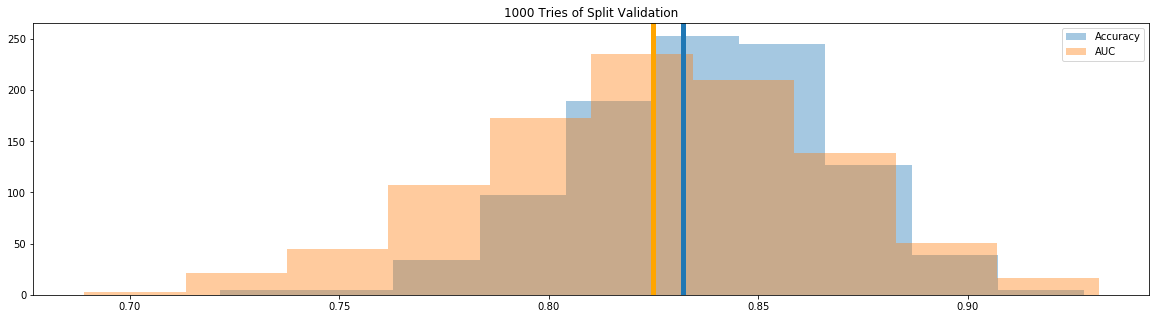

Accuracy mean: 0.83
AUC mean: 0.82


In [52]:
plt.figure(figsize=(20,5))
plt.title("1000 Tries of Split Validation")
sns.distplot(accuracy_list, bins=10, label = 'Accuracy', kde=False)
sns.distplot(auc_list, bins=10, label = 'AUC', kde=False)
plt.axvline(x=pd.Series(accuracy_list).mean(), lw=5)
plt.axvline(x=pd.Series(auc_list).mean(), lw=5, color='orange')
plt.legend()
plt.show()
print("Accuracy mean: %0.2f" % pd.Series(accuracy_list).mean())
print("AUC mean: %0.2f" % pd.Series(auc_list).mean())

## Dump To Pickle

In [53]:
clf = model_choice
clf = clf.fit(X, y)
pickle.dump(clf, open('../models/final_prediction.pickle', 'wb'))

In [54]:
# feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
# feat_imp.plot(kind='bar', title='Feature Importances')
# plt.ylabel('Feature Importance Score')
# plt.show()